__Purpose:__ Test the performance of already trained decoders to see if they continue to achieve the best performance, and to see if personalization is necessary/possible.  Ideally, this NB should show that the outputs of previous training rounds will maintain their high performance.  I am ambivalent about whether or not we would expect any further improvement over training.

In [1]:
import pandas as pd
import os
import numpy as np
np.random.seed(0)
import random
random.seed(0)
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

#import seaborn as sns
#from presentation_sns_config import *

from experiment_params import *
from cost_funcs import *
from fl_sim_client import *
from fl_sim_server import *
import time
import pickle
from sklearn.decomposition import PCA

from scipy.optimize import minimize, least_squares
from itertools import permutations

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# NoFL (200P)

In [3]:
# For condition 1:
alpha = .25 # higher alpha means more old decoder (slower update)
alphaD = 1e-3
alphaF = 0
first_half = 14  # Used to be 7, idk why I only wanted to use half
total_num_updates = 19
final_training_update = 15
starting_update = 0 # This is not used anywhere else except directly below FYI 
num_updates = final_training_update - starting_update
dt = 1/60

#############################################################

poster_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting"

cost_df_FLSim = pd.read_csv(poster_path + r"\200P_train_cost_df_noPCA_yesEMGNorm_FLSim.csv")
test_cost_df_FLSim = pd.read_csv(poster_path + r"\200P_test_cost_df_noPCA_yesEMGNorm_FLSim.csv")

cost_df_FLSim_PCA10 = pd.read_csv(poster_path + r"\200P_train_cost_df_PCA10_yesEMGNorm_FLSim.csv")
test_cost_df_FLSim_PCA10 = pd.read_csv(poster_path + r"\200P_test_cost_df_PCA10_yesEMGNorm_FLSim.csv")

cost_df = pd.read_csv(poster_path + r"\200P_train_cost_df.csv")
test_cost_df = pd.read_csv(poster_path + r"\200P_test_cost_df.csv")
test_cost_df_postSB = pd.read_csv(poster_path + r"\200P_test_cost_df_postSB.csv")


print(cost_df_FLSim.shape)
cost_df_FLSim.drop('Unnamed: 0', axis=1, inplace=True)
print(test_cost_df_FLSim.shape)
test_cost_df_FLSim.drop('Unnamed: 0', axis=1, inplace=True)

print(cost_df_FLSim_PCA10.shape)
cost_df_FLSim_PCA10.drop('Unnamed: 0', axis=1, inplace=True)
print(test_cost_df_FLSim_PCA10.shape)
test_cost_df_FLSim_PCA10.drop('Unnamed: 0', axis=1, inplace=True)

print(cost_df.shape)
cost_df.drop('Unnamed: 0', axis=1, inplace=True)
print(test_cost_df.shape)
test_cost_df.drop('Unnamed: 0', axis=1, inplace=True)
print(test_cost_df_postSB.shape)
test_cost_df_postSB.drop('Unnamed: 0', axis=1, inplace=True)

(15, 16)
(15, 16)
(15, 16)
(15, 16)
(15, 16)
(15, 16)
(15, 16)


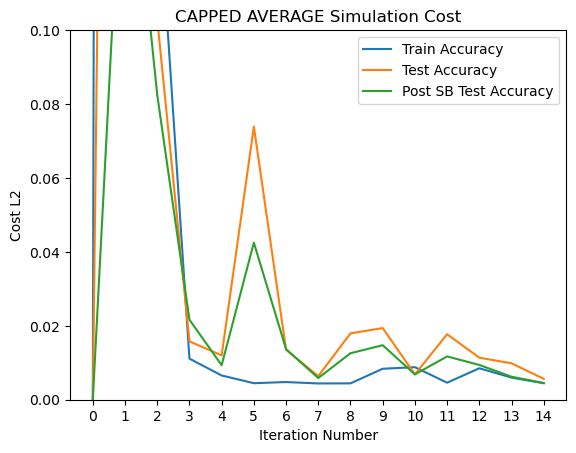

In [4]:
step_indices = list(range(num_updates))
plt.plot(cost_df.iloc[-1,:], label="Train Accuracy")
plt.plot(test_cost_df.iloc[-1,:], label="Test Accuracy")
plt.plot(test_cost_df_postSB.iloc[-1,:], label="Post SB Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

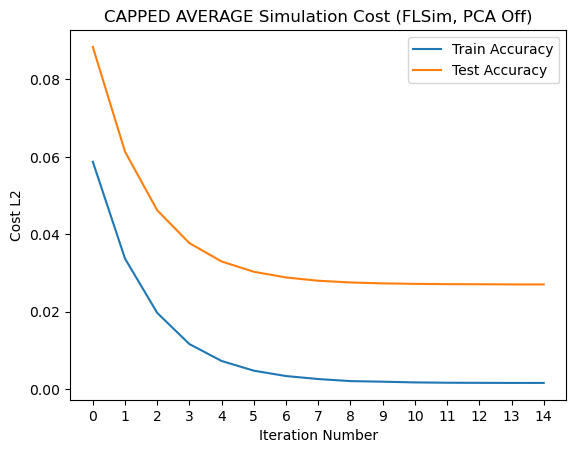

In [5]:
step_indices = list(range(num_updates))
plt.plot(cost_df_FLSim.iloc[-1,:], label="Train Accuracy")
plt.plot(test_cost_df_FLSim.iloc[-1,:], label="Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost (FLSim, PCA Off)')
#plt.ylim(0, 0.1)
plt.legend()
plt.show()

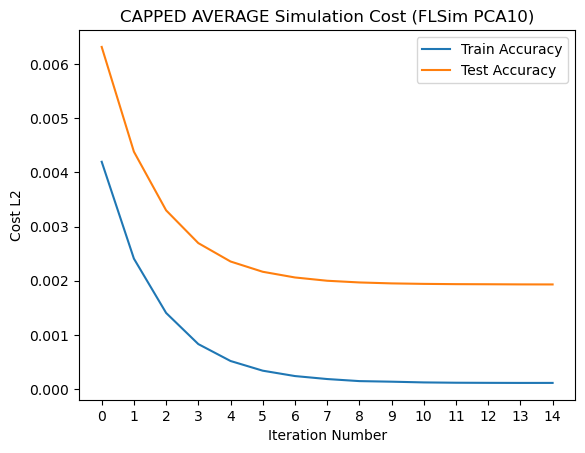

In [6]:
step_indices = list(range(num_updates))
plt.plot(cost_df_FLSim_PCA10.iloc[-1,:], label="Train Accuracy")
plt.plot(test_cost_df_FLSim_PCA10.iloc[-1,:], label="Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost (FLSim PCA10)')
#plt.ylim(0, 0.1)
plt.legend()
plt.show()

# Federated Learning
## 1 Scipy Step, 600 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

In [5]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

D_0 = np.random.rand(2,64)
D_0_10 = np.random.rand(2,10)

In [9]:
step_indices = list(range(num_updates))

In [6]:
user_c0_1ScipyStep = [Client(i, D_0_10, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=0, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_10, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 600
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()


Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 133, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 287, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 458, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (4, 566, 200)



In [7]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
        7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

def moving_average(numbers, window_size):
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += window_size
    return moving_averages

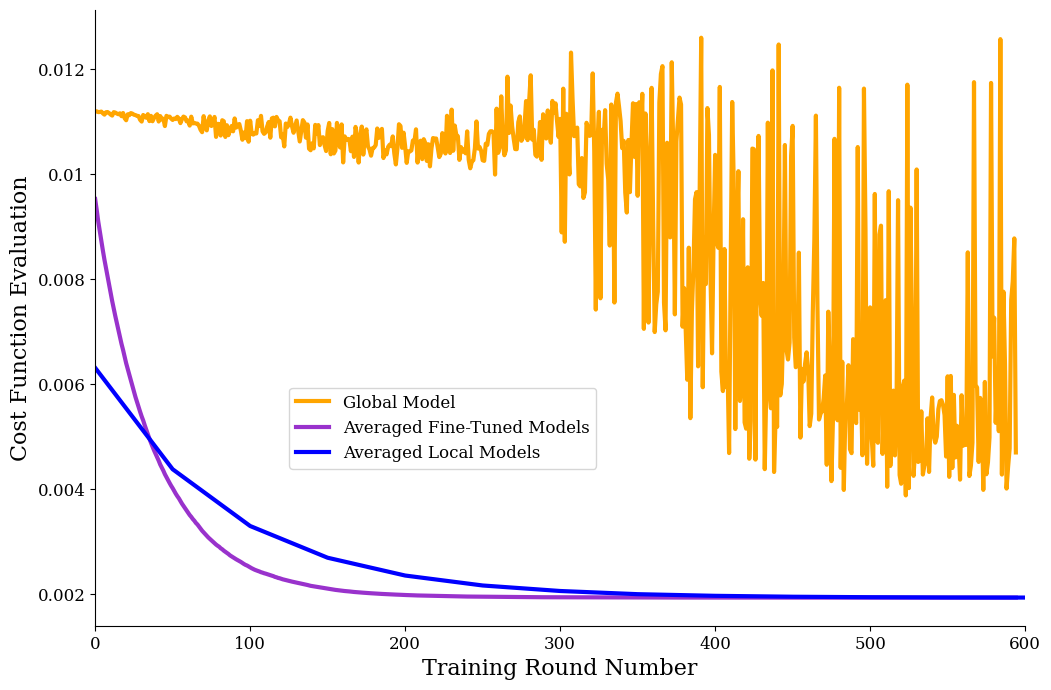

In [10]:
my_title = 'Decoding Model Testing Error'
iterable_labels = ['Global Model', 'Averaged Fine-Tuned Models']
# iterable_labels = []

# all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])
all_user_input = [user_c0_1ScipyStep]

plot_mean = True
plot_median = False
exclusion_ID_lst = []
dim_reduc_factor = 1
plot_this_ID_only = -1
global_error = True
local_error = True
different_local_round_thresh_per_client = False
legend_on = True
num_participants = 14
show_update_change = True
custom_title = ""
axes_off_list = []
xlim_max = None
xlim_min = None
ylim_max = None
ylim_min = None
input_linewidth = 3
my_legend_loc = 'best'
iterable_colors = []

plot_testing = True
plot_training = False

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0

axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize based on your poster size

# Define colors for plotting
colors = {'GLOBAL': 'orange', 'LOCAL': 'darkorchid', 'PERS': 'blue'}

# Iterate through the data
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue
        elif len(user_database[i].local_error_log) < 2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue
        else:
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])

    all_dfs_dict = {
        0: 0, 1: 1, 2: 2, 3: global_training_df.reset_index(drop=True), 4: local_training_df.reset_index(drop=True),
        5: 5, 6: 6, 7: 7, 8: 8, 9: global_testing_df.reset_index(drop=True), 10: local_testing_df.reset_index(drop=True)
    }

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    label_idx = 0
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean == True and vec_idx == 0) or (plot_median == True and vec_idx == 1):
                    if iterable_labels != []:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    linestyle = 'dashed' if "GLOBAL:" in my_label.upper() else 'solid'
                    #my_color = colors.get([key for key in colors.keys() if key in my_label.upper()][0], 'black')
                    my_color = 'orange' if ('GLOBAL' in my_label.upper()) else 'darkorchid'
                    saved_vec = np.array(vec_vec)
                    x_axis = range(len(vec_vec))
                    ax.plot(x_axis[:-5], vec_vec[:-5], label=my_label, alpha=1, color=my_color,
                            linewidth=input_linewidth, linestyle=linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices) * 50  # Maybe ought to use 100...

# FLSIM PCA 10
ax.plot(scaled_step_indices[:-2], test_cost_df_FLSim_PCA10.iloc[-1, :-2], linewidth=input_linewidth, label="Averaged Local Models", color='blue')

ax.set_ylabel('Cost Function Evaluation', fontdict=axes_font)  # Adjust font size
ax.set_xlabel('Training Round Number', fontdict=axes_font)  # Adjust font size
#ax1.set_title('Adversarial Model Accuracy Per Data Batch', fontdict=title_font)

#ax.set_title(my_title, fontsize=36)  # Adjust font size
#ax.set_ylim(0, 0.016)
ax.set_xlim(0, 600)

xtick_positions = np.arange(0, 601, 100)
xtick_labels = [str(pos) for pos in xtick_positions]  # Convert positions to strings
tick_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.xticks(xtick_positions, xtick_labels, fontdict=tick_font)
#ax1.set_xticklabels(xtick_labels, fontdict=tick_font)

ytick_positions = np.arange(0.002, 0.014, 0.002)
ytick_labels = [str(pos) for pos in ytick_positions]  # Convert positions to strings
plt.yticks(ytick_positions, ytick_labels, fontdict=tick_font)

legend_font = {'family': 'serif', 'size': 12}
ax.legend(loc='upper left', prop=legend_font, bbox_to_anchor=(0.2, 0.4))  # Adjust legend font size
ax.spines[['right', 'top']].set_visible(False)

plt.show()


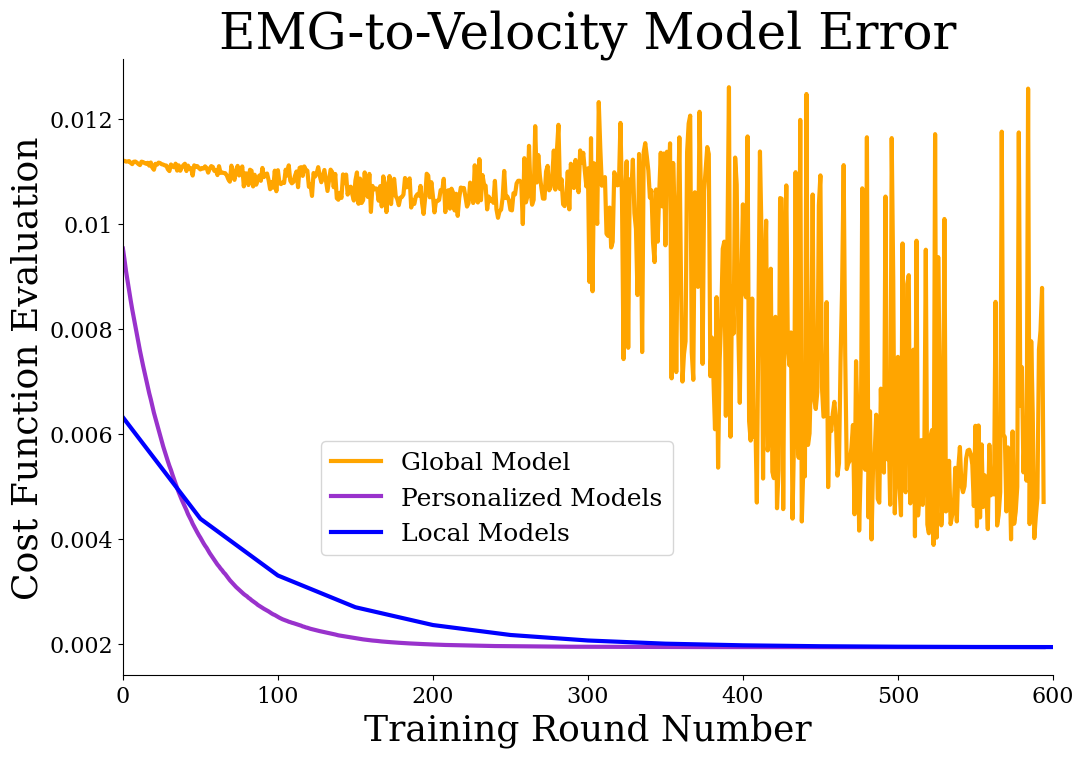

In [17]:
my_title = 'EMG-to-Velocity Model Error'
iterable_labels = ['Global Model', 'Personalized Models']
# iterable_labels = []

# all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])
all_user_input = [user_c0_1ScipyStep]

plot_mean = True
plot_median = False
exclusion_ID_lst = []
dim_reduc_factor = 1
plot_this_ID_only = -1
global_error = True
local_error = True
different_local_round_thresh_per_client = False
legend_on = True
num_participants = 14
show_update_change = True
custom_title = ""
axes_off_list = []
xlim_max = None
xlim_min = None
ylim_max = None
ylim_min = None
input_linewidth = 3
my_legend_loc = 'best'
iterable_colors = []

plot_testing = True
plot_training = False

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0

axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize based on your poster size

# Define colors for plotting
colors = {'GLOBAL': 'orange', 'LOCAL': 'darkorchid', 'PERS': 'blue'}

# Iterate through the data
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue
        elif len(user_database[i].local_error_log) < 2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue
        else:
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])

    all_dfs_dict = {
        0: 0, 1: 1, 2: 2, 3: global_training_df.reset_index(drop=True), 4: local_training_df.reset_index(drop=True),
        5: 5, 6: 6, 7: 7, 8: 8, 9: global_testing_df.reset_index(drop=True), 10: local_testing_df.reset_index(drop=True)
    }

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    label_idx = 0
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean == True and vec_idx == 0) or (plot_median == True and vec_idx == 1):
                    if iterable_labels != []:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    linestyle = 'dashed' if "GLOBAL:" in my_label.upper() else 'solid'
                    #my_color = colors.get([key for key in colors.keys() if key in my_label.upper()][0], 'black')
                    my_color = 'orange' if ('GLOBAL' in my_label.upper()) else 'darkorchid'
                    saved_vec = np.array(vec_vec)
                    x_axis = range(len(vec_vec))
                    ax.plot(x_axis[:-5], vec_vec[:-5], label=my_label, alpha=1, color=my_color,
                            linewidth=input_linewidth, linestyle=linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices) * 50  # Maybe ought to use 100...

# FLSIM PCA 10
ax.plot(scaled_step_indices[:-2], test_cost_df_FLSim_PCA10.iloc[-1, :-2], linewidth=input_linewidth, label="Local Models", color='blue')

ticks_font_size = 18
axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 26}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 36}
ticks_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': ticks_font_size}
legend_font = {'family': 'serif', 'size': 18}

ax.set_ylabel('Cost Function Evaluation', fontdict=axes_font)  # Adjust font size
ax.set_xlabel('Training Round Number', fontdict=axes_font)  # Adjust font size
#ax1.set_title('Adversarial Model Accuracy Per Data Batch', fontdict=title_font)

ax.set_title("EMG-to-Velocity Model Error", fontdict=title_font)  # Adjust font size
#ax.set_ylim(0, 0.016)
ax.set_xlim(0, 600)

xtick_positions = np.arange(0, 601, 100)
xtick_labels = [str(pos) for pos in xtick_positions]  # Convert positions to strings
plt.xticks(xtick_positions, xtick_labels, fontdict=tick_font)
#ax1.set_xticklabels(xtick_labels, fontdict=tick_font)

ytick_positions = np.arange(0.002, 0.014, 0.002)
ytick_labels = [str(pos) for pos in ytick_positions]  # Convert positions to strings
plt.yticks(ytick_positions, ytick_labels, fontdict=tick_font)

ax.legend(loc='upper left', prop=legend_font, bbox_to_anchor=(0.2, 0.4))  # Adjust legend font size
ax.spines[['right', 'top']].set_visible(False)

plt.show()


# Exploring Effects of Initialization

EXISTING RESULTS (SRI)


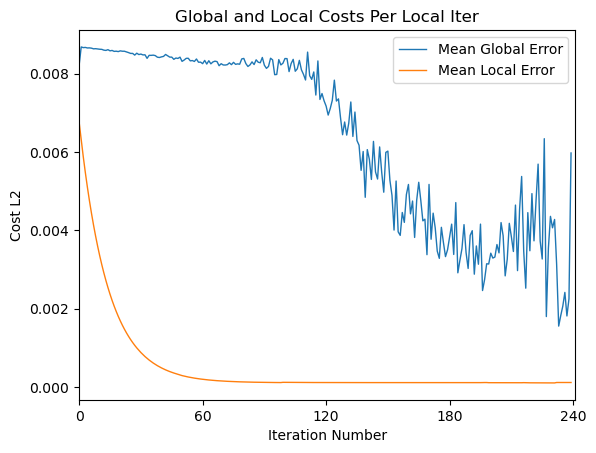

In [18]:
print("EXISTING RESULTS (SRI)")
_ = central_tendency_plotting([user_c0_1ScipyStep], plot_mean=True, global_error=True, local_error=True, show_update_change=False, iterable_labels=[], iterable_colors=[])

ALL USING PREV GLOBAL MODEL
Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 136, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 250, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 407, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (4, 552, 200)



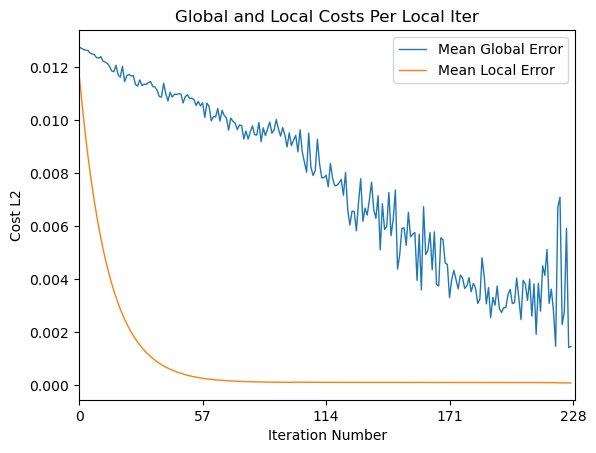

In [19]:
print("ALL USING PREV GLOBAL MODEL")
user_prevglobalinit = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=0, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_prevglobalinit = Server(1, global_model_1scipystep.w, 'FedAvg', user_prevglobalinit)

big_loop_iters = 600
for i in range(big_loop_iters):
    global_prevglobalinit.execute_FL_loop()
    
_ = central_tendency_plotting([user_prevglobalinit], plot_mean=True, global_error=True, local_error=True, show_update_change=False, iterable_labels=[], iterable_colors=[])

GLOBAL USING GLOBAL ONLY, OTHERS HAVE SRI
Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 129, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 253, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 391, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (4, 527, 200)



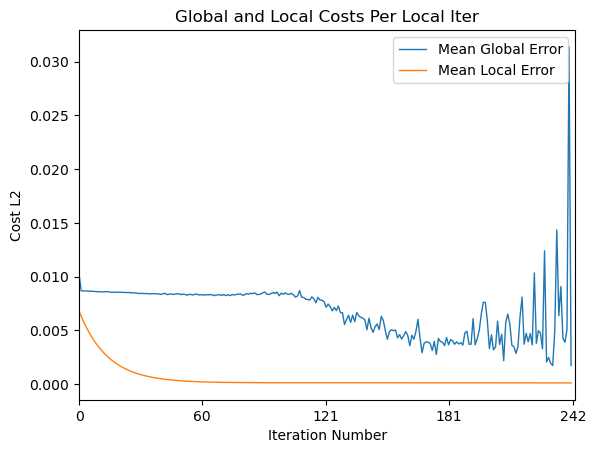

In [20]:
print("GLOBAL USING GLOBAL ONLY, OTHERS HAVE SRI")
user_SRI2 = [Client(i, D_0_10, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=0, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_prevglobalinit2 = Server(1, global_model_1scipystep.w, 'FedAvg', user_SRI2)

big_loop_iters = 600
for i in range(big_loop_iters):
    global_prevglobalinit2.execute_FL_loop()
    
_ = central_tendency_plotting([user_SRI2], plot_mean=True, global_error=True, local_error=True, show_update_change=False, iterable_labels=[], iterable_colors=[])

ALL PREV: CLIENTS USING THEIR PREV, GLOBAL USING ITS PREV
Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 163, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 287, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 421, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (4, 566, 200)



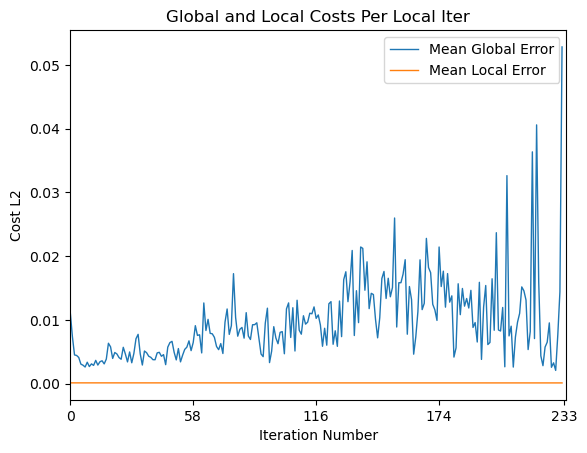

In [21]:
print("ALL PREV: CLIENTS USING THEIR PREV, GLOBAL USING ITS PREV")

user_prevflinit = [Client(i, user_c0_1ScipyStep[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=0, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_prevglobalinit3 = Server(1, global_model_1scipystep.w, 'FedAvg', user_prevflinit)

big_loop_iters = 600
for i in range(big_loop_iters):
    global_prevglobalinit3.execute_FL_loop()
    
_ = central_tendency_plotting([user_prevflinit], plot_mean=True, global_error=True, local_error=True, show_update_change=False, iterable_labels=[], iterable_colors=[])

In [29]:
all_user_input = [user_c0_1ScipyStep, user_prevglobalinit, user_SRI2, user_prevflinit]
my_title = 'Decoding Model Testing Error'
iterable_labels = ['SRI Global Model', 'SRI Averaged Fine-Tuned Models', 
                   'PrevGM Global Model', 'PrevGM Averaged Fine-Tuned Models', 
                   'PrevGM2 Global Model', 'SRI2 Averaged Fine-Tuned Models', 
                   'PrevGM3 Global Model', 'PrevUMs Averaged Fine-Tuned Models']
iterable_colors = ['black', 'silver', 'lightcoral', 'darkred', 'red', 'darkorange', 'olive', 'darkolivegreen', 'lawngreen', 'cyan', 'dodgerblue', 'rebeccapurple', 'plum', 'fuchsia', 'deeppink']
# 'goldenrod', 'saddlebrown',

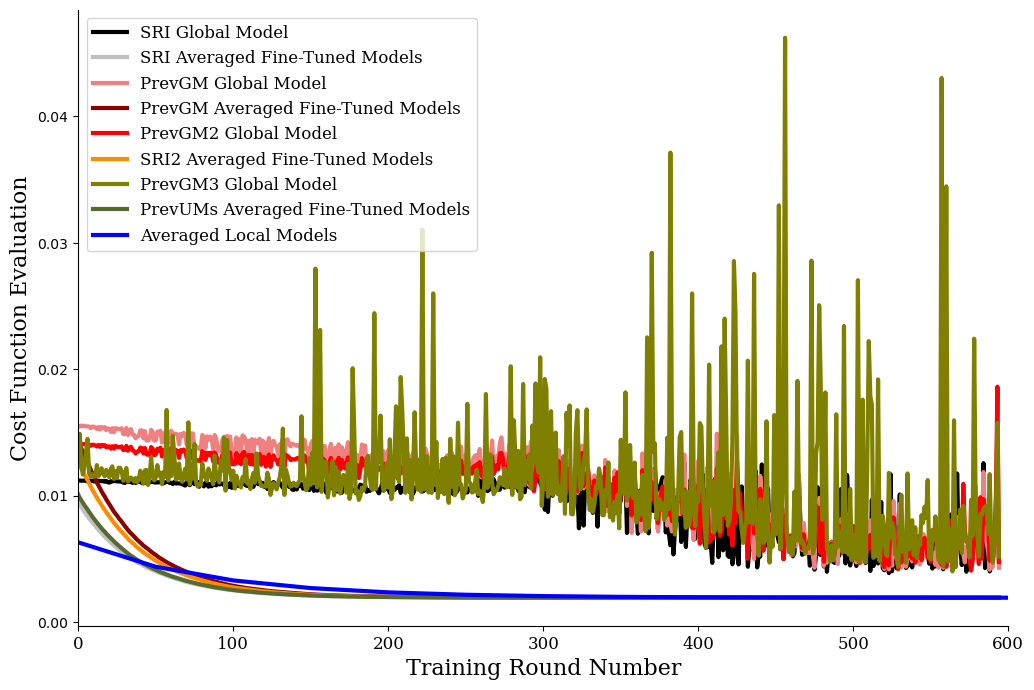

In [31]:
# all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])

plot_mean = True
plot_median = False
exclusion_ID_lst = []
dim_reduc_factor = 1
plot_this_ID_only = -1
global_error = True
local_error = True
different_local_round_thresh_per_client = False
legend_on = True
num_participants = 14
show_update_change = True
custom_title = ""
axes_off_list = []
xlim_max = None
xlim_min = None
ylim_max = None
ylim_min = None
input_linewidth = 3
my_legend_loc = 'best'

plot_testing = True
plot_training = False

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0

axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize based on your poster size

# Define colors for plotting
colors = {'GLOBAL': 'orange', 'LOCAL': 'darkorchid', 'PERS': 'blue'}
label_idx = 0
color_idx = 0
# Iterate through the data
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue
        elif len(user_database[i].local_error_log) < 2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue
        else:
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])

    all_dfs_dict = {
        0: 0, 1: 1, 2: 2, 3: global_training_df.reset_index(drop=True), 4: local_training_df.reset_index(drop=True),
        5: 5, 6: 6, 7: 7, 8: 8, 9: global_testing_df.reset_index(drop=True), 10: local_testing_df.reset_index(drop=True)
    }

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    #label_idx = 0
    #color_idx = 0
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean == True and vec_idx == 0) or (plot_median == True and vec_idx == 1):
                    if iterable_labels != []:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    if iterable_colors != []:
                        my_color = iterable_colors[color_idx]
                        color_idx += 1
                    else:
                        #my_color = colors.get([key for key in colors.keys() if key in my_label.upper()][0], 'black')
                        my_color = 'orange' if ('GLOBAL' in my_label.upper()) else 'darkorchid'
                    linestyle = 'dashed' if "GLOBAL:" in my_label.upper() else 'solid'
                    saved_vec = np.array(vec_vec)
                    x_axis = range(len(vec_vec))
                    ax.plot(x_axis[:-5], vec_vec[:-5], label=my_label, alpha=1, color=my_color,
                            linewidth=input_linewidth, linestyle=linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices) * 50  # Maybe ought to use 100...

# FLSIM PCA 10
ax.plot(scaled_step_indices[:-2], test_cost_df_FLSim_PCA10.iloc[-1, :-2], linewidth=input_linewidth, label="Averaged Local Models", color='blue')

ax.set_ylabel('Cost Function Evaluation', fontdict=axes_font)  # Adjust font size
ax.set_xlabel('Training Round Number', fontdict=axes_font)  # Adjust font size
#ax1.set_title('Adversarial Model Accuracy Per Data Batch', fontdict=title_font)

#ax.set_title(my_title, fontsize=36)  # Adjust font size
#ax.set_ylim(0, 0.016)
ax.set_xlim(0, 600)

xtick_positions = np.arange(0, 601, 100)
xtick_labels = [str(pos) for pos in xtick_positions]  # Convert positions to strings
tick_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.xticks(xtick_positions, xtick_labels, fontdict=tick_font)
#ax1.set_xticklabels(xtick_labels, fontdict=tick_font)

#ytick_positions = np.arange(0.002, 0.014, 0.002)
#ytick_labels = [str(pos) for pos in ytick_positions]  # Convert positions to strings
#plt.yticks(ytick_positions, ytick_labels, fontdict=tick_font)

legend_font = {'family': 'serif', 'size': 12}
ax.legend(loc='upper left', prop=legend_font)#, bbox_to_anchor=(0.2, 0.4))  # Adjust legend font size
ax.spines[['right', 'top']].set_visible(False)

plt.show()


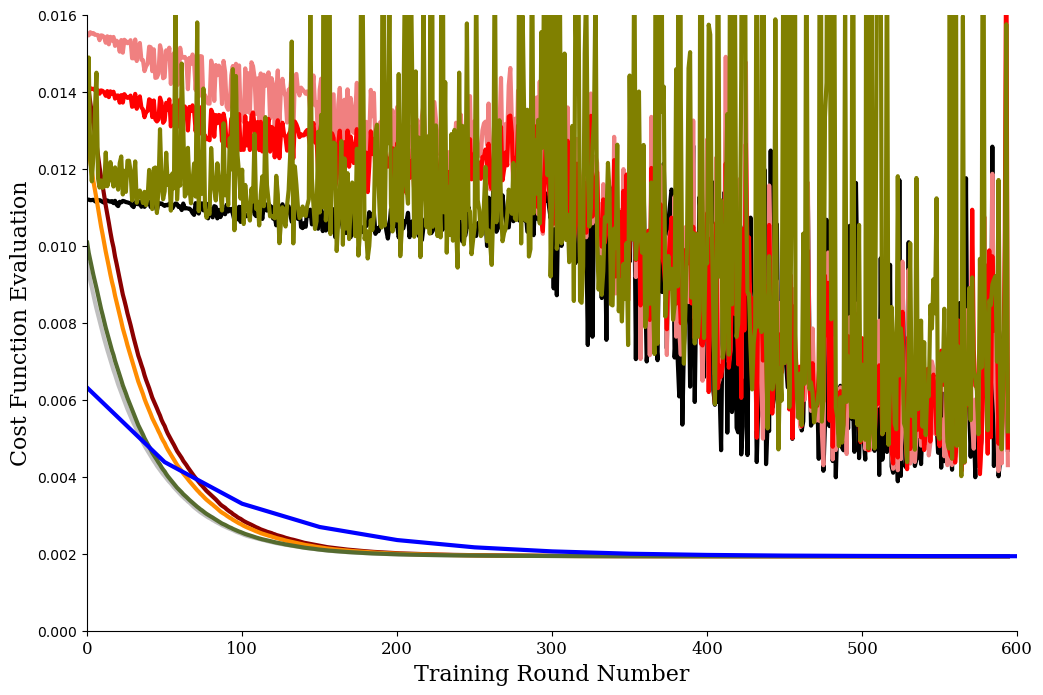

In [33]:
# all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])

plot_mean = True
plot_median = False
exclusion_ID_lst = []
dim_reduc_factor = 1
plot_this_ID_only = -1
global_error = True
local_error = True
different_local_round_thresh_per_client = False
legend_on = True
num_participants = 14
show_update_change = True
custom_title = ""
axes_off_list = []
xlim_max = None
xlim_min = None
ylim_max = None
ylim_min = None
input_linewidth = 3
my_legend_loc = 'best'

plot_testing = True
plot_training = False

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0

axes_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
title_font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 22}

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figsize based on your poster size

# Define colors for plotting
colors = {'GLOBAL': 'orange', 'LOCAL': 'darkorchid', 'PERS': 'blue'}
label_idx = 0
color_idx = 0
# Iterate through the data
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue
        elif len(user_database[i].local_error_log) < 2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue
        else:
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])
                if local_error:
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index // dim_reduc_factor, axis=0).mean()).T])

    all_dfs_dict = {
        0: 0, 1: 1, 2: 2, 3: global_training_df.reset_index(drop=True), 4: local_training_df.reset_index(drop=True),
        5: 5, 6: 6, 7: 7, 8: 8, 9: global_testing_df.reset_index(drop=True), 10: local_testing_df.reset_index(drop=True)
    }

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    #label_idx = 0
    #color_idx = 0
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean == True and vec_idx == 0) or (plot_median == True and vec_idx == 1):
                    if iterable_labels != []:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    if iterable_colors != []:
                        my_color = iterable_colors[color_idx]
                        color_idx += 1
                    else:
                        #my_color = colors.get([key for key in colors.keys() if key in my_label.upper()][0], 'black')
                        my_color = 'orange' if ('GLOBAL' in my_label.upper()) else 'darkorchid'
                    linestyle = 'dashed' if "GLOBAL:" in my_label.upper() else 'solid'
                    saved_vec = np.array(vec_vec)
                    x_axis = range(len(vec_vec))
                    ax.plot(x_axis[:-5], vec_vec[:-5], label=my_label, alpha=1, color=my_color,
                            linewidth=input_linewidth, linestyle=linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices) * 50  # Maybe ought to use 100...

# FLSIM PCA 10
ax.plot(scaled_step_indices[:-2], test_cost_df_FLSim_PCA10.iloc[-1, :-2], linewidth=input_linewidth, label="Averaged Local Models", color='blue')

ax.set_ylabel('Cost Function Evaluation', fontdict=axes_font)  # Adjust font size
ax.set_xlabel('Training Round Number', fontdict=axes_font)  # Adjust font size
#ax1.set_title('Adversarial Model Accuracy Per Data Batch', fontdict=title_font)

#ax.set_title(my_title, fontsize=36)  # Adjust font size
ax.set_ylim(0, 0.016)
ax.set_xlim(0, 600)

xtick_positions = np.arange(0, 601, 100)
xtick_labels = [str(pos) for pos in xtick_positions]  # Convert positions to strings
tick_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.xticks(xtick_positions, xtick_labels, fontdict=tick_font)
#ax1.set_xticklabels(xtick_labels, fontdict=tick_font)

#ytick_positions = np.arange(0.002, 0.014, 0.002)
#ytick_labels = [str(pos) for pos in ytick_positions]  # Convert positions to strings
#plt.yticks(ytick_positions, ytick_labels, fontdict=tick_font)

#legend_font = {'family': 'serif', 'size': 12}
#ax.legend(loc='upper left', prop=legend_font)#, bbox_to_anchor=(0.2, 0.4))  # Adjust legend font size
ax.spines[['right', 'top']].set_visible(False)

plt.show()


Oof